In [1]:
import sys, os, time
import torch
sys.path.append("../src/")
from run_pdebench_finetuning import get_args, get_model, build_pdebench_dataset
from engine_for_pdebench_finetuning import get_targets, unnorm_batch
import utils
from einops import rearrange
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [18]:
model_dir = 'pdebench_finetuning/ssv2_b/final_runs/ssv2_b_turb_512_0.8'
# model_dir = 'pdebench_finetuning/k400_s/k400_s_turb_512_4chan_test_2'

args_json = os.path.join(utils.get_ceph_dir(), model_dir, "args.json")
args = utils.load_args(args_json)

args.num_workers = 1
args.device = 'cuda:0'
args.checkpoint = os.path.join(model_dir, 'checkpoint-499')

In [19]:
print("Dataset:\t\t", args.data_set)
print("Fields:\t\t\t", args.fields)
print("Model:\t\t\t", args.model)
print("Checkpoint:\t\t", args.checkpoint)
print("Batch size:\t\t", args.batch_size)
print("Number of workers:\t", args.num_workers)
print("Mask type:\t\t", args.mask_type)
print("Mask ratio:\t\t", args.mask_ratio)
print("Norm target mode:\t", args.norm_target_mode)
print("Num frames:\t\t", args.num_frames)
print("Device:\t\t\t", args.device)

Dataset:		 compNS_turb
Fields:			 ['Vx', 'Vy', 'density', 'pressure']
Model:			 pretrain_videomae_base_patch16_512_4chan_18f
Checkpoint:		 pdebench_finetuning/ssv2_b/final_runs/ssv2_b_turb_512_0.8/checkpoint-499
Batch size:		 1
Number of workers:	 1
Mask type:		 last_frame
Mask ratio:		 0.9
Norm target mode:	 last_frame
Num frames:		 18
Device:			 cuda:0


In [20]:
device = torch.device(args.device)

# Load model
model = get_model(args)
model.to(device)
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Model loaded")
print('number of params: {} M'.format(n_parameters / 1e6))

# Load dataset
dataset = build_pdebench_dataset(args, set_type='test')
dataset.random_start = False

# Data loader
# sampler = torch.utils.data.RandomSampler(dataset)
sampler = torch.utils.data.SequentialSampler(dataset)
data_loader = torch.utils.data.DataLoader(
        dataset, sampler=sampler,
        batch_size=args.batch_size,
        num_workers=args.num_workers,
        pin_memory=args.pin_mem,
        drop_last=True,
        worker_init_fn=utils.seed_worker)

Creating model: pretrain_videomae_base_patch16_512_4chan_18f
Position interpolate from 8x14x14 to 9x32x32
Position interpolate from 8x14x14 to 9x32x32
Adapting checkpoint for PDEBench
Model loaded
number of params: 94.80128 M
Loading dataset file /mnt/home/gkrawezik/ceph/AI_DATASETS/PDEBench/2D/CFD/2D_Train_Turb/2D_CFD_Turb_M1.0_Eta1e-08_Zeta1e-08_periodic_512_Train.hdf5
Raw dataset compNS_turb has 1000 samples of shape (512, 512) and 21 timesteps.


In [21]:
def plot_reconstruction(samples, recon, mask, batch_index=None, frame_index=None, patch_size=(2, 16, 16)):
    p0, p1, p2 = patch_size
    h, w = args.input_size // p1, args.input_size // p2

    truth = samples

    truth_masked = samples
    truth_masked = rearrange(samples, 'b c (t p0) (h p1) (w p2) -> b (t h w) (p0 p1 p2 c)', p0=p0, p1=p1, p2=p2)
    truth_masked[mask] = torch.nan
    truth_masked = rearrange(truth_masked, 'b (t h w) (p0 p1 p2 c) -> b c (t p0) (h p1) (w p2)', p0=p0, p1=p1, p2=p2, h=h, w=w)

    recon_full = rearrange(samples, 'b c (t p0) (h p1) (w p2) -> b (t h w) (p0 p1 p2 c)', p0=p0, p1=p1, p2=p2)
    recon_full[mask] = recon.flatten(start_dim=0, end_dim=1)
    recon_full = rearrange(recon_full, 'b (t h w) (p0 p1 p2 c) -> b c (t p0) (h p1) (w p2)', p0=p0, p1=p1, p2=p2, h=h, w=w)

    if batch_index is None:
        batch_index = np.random.randint(0, args.batch_size)
    if frame_index is None:
        frame_index = np.random.randint(0, args.num_frames)

    truth = truth[batch_index, :, frame_index]
    recon_full = recon_full[batch_index, :, frame_index]
    truth_masked = truth_masked[batch_index, :, frame_index]

    bins = torch.linspace(0, np.pi, 100)
    bins, ps_truth, _ = utils.power_spectrum_iso2d(truth.unsqueeze(0), bins=bins)
    bins, ps_recon, _ = utils.power_spectrum_iso2d(recon_full.unsqueeze(0), bins=bins)
    bins, ps_resid, _ = utils.power_spectrum_iso2d((recon_full - truth).unsqueeze(0), bins=bins)

    truth = truth.cpu().numpy()
    recon_full = recon_full.cpu().numpy()
    truth_masked = truth_masked.cpu().numpy()

    bins = bins.cpu().numpy()
    ps_truth = ps_truth.cpu().numpy()[0]
    ps_recon = ps_recon.cpu().numpy()[0]
    ps_resid = ps_resid.cpu().numpy()[0]

    vmin = np.min(truth, axis=(-1, -2))
    vmax = np.max(truth, axis=(-1, -2))

    fig, axs = plt.subplots(4, len(args.fields), figsize=(3*len(args.fields), 12), sharex=True, sharey=True)
    for i in range(len(args.fields)):
        axs[0, i].imshow(truth_masked[i], vmin=vmin[i], vmax=vmax[i])
        axs[0, i].set_title(f'Field: {args.fields[i]}')
        axs[1, i].imshow(recon_full[i], vmin=vmin[i], vmax=vmax[i])
        axs[2, i].imshow(truth[i], vmin=vmin[i], vmax=vmax[i])
        axs[3, i].imshow(recon_full[i] - truth[i], vmin=vmin[i] - truth[i].mean(), vmax=vmax[i] - truth[i].mean())
    axs[0, 0].set_ylabel('Input')
    axs[1, 0].set_ylabel('Reconstruction')
    axs[2, 0].set_ylabel('Truth')
    axs[3, 0].set_ylabel('Residual')
    fig.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, len(args.fields), figsize=(3*len(args.fields), 3.5), sharex=True, sharey=True)
    for i in range(len(args.fields)):
        axs[i].plot(bins, ps_truth[i, i], label='Truth')
        axs[i].plot(bins, ps_recon[i, i], label='Recon')
        axs[i].plot(bins, ps_resid[i, i], label='Resid')
        axs[i].set_title(f'Field: {args.fields[i]}')
        axs[i].set_xlabel('k')
    axs[0].set_ylabel('P(k)')
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].legend()
    fig.tight_layout()

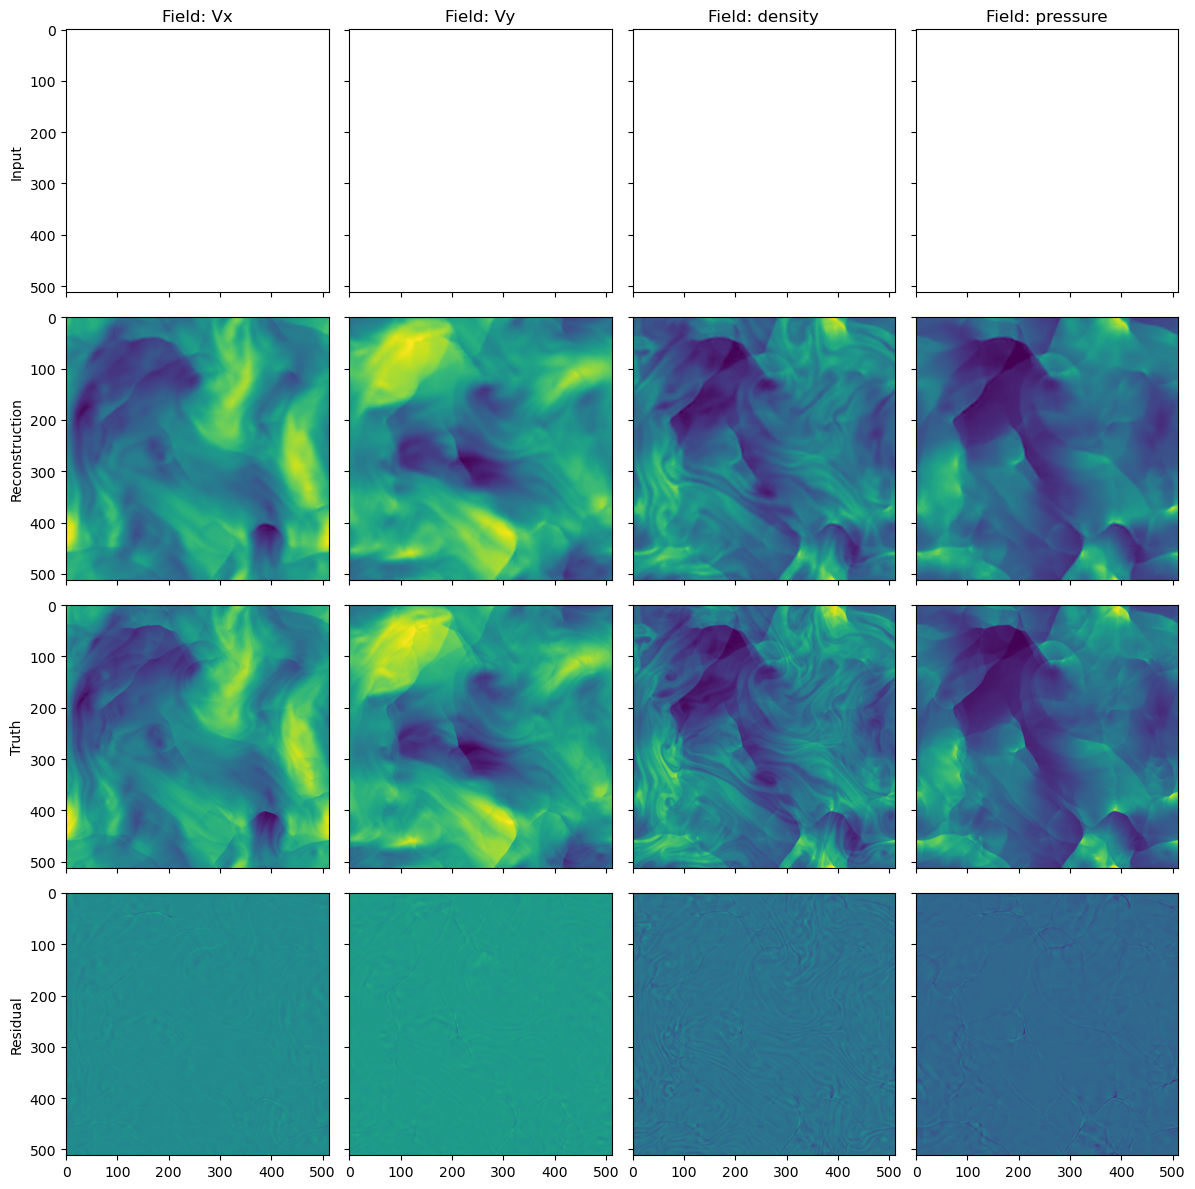

MSE Loss: 0.006770576816052198


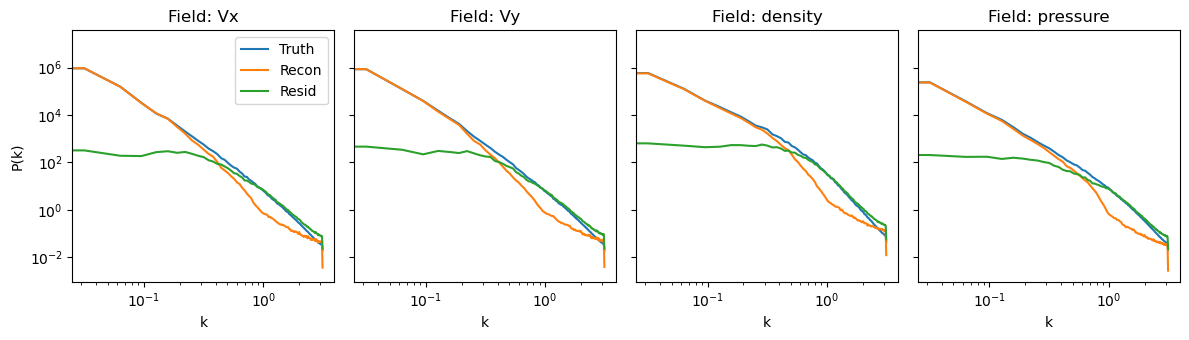

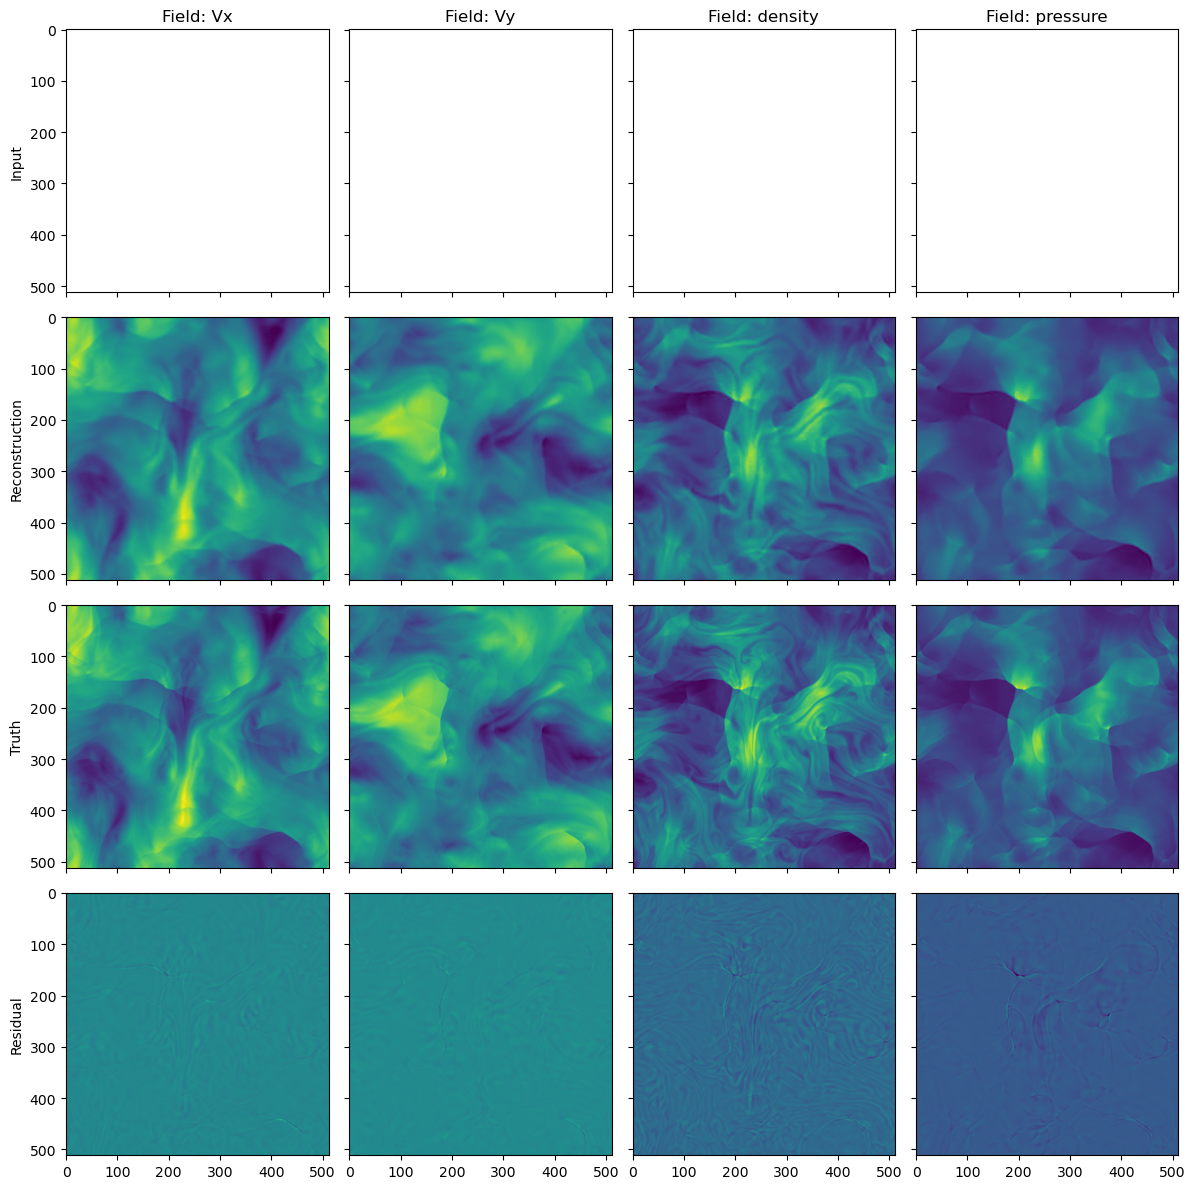

MSE Loss: 0.008931771852076054


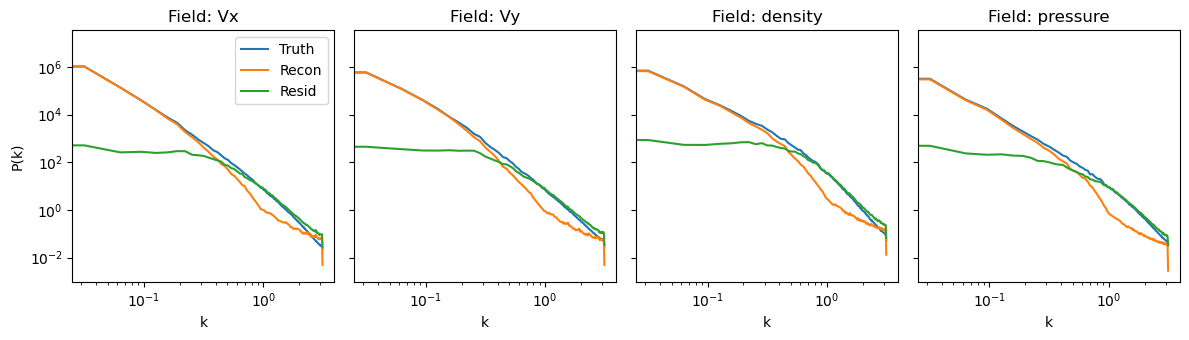

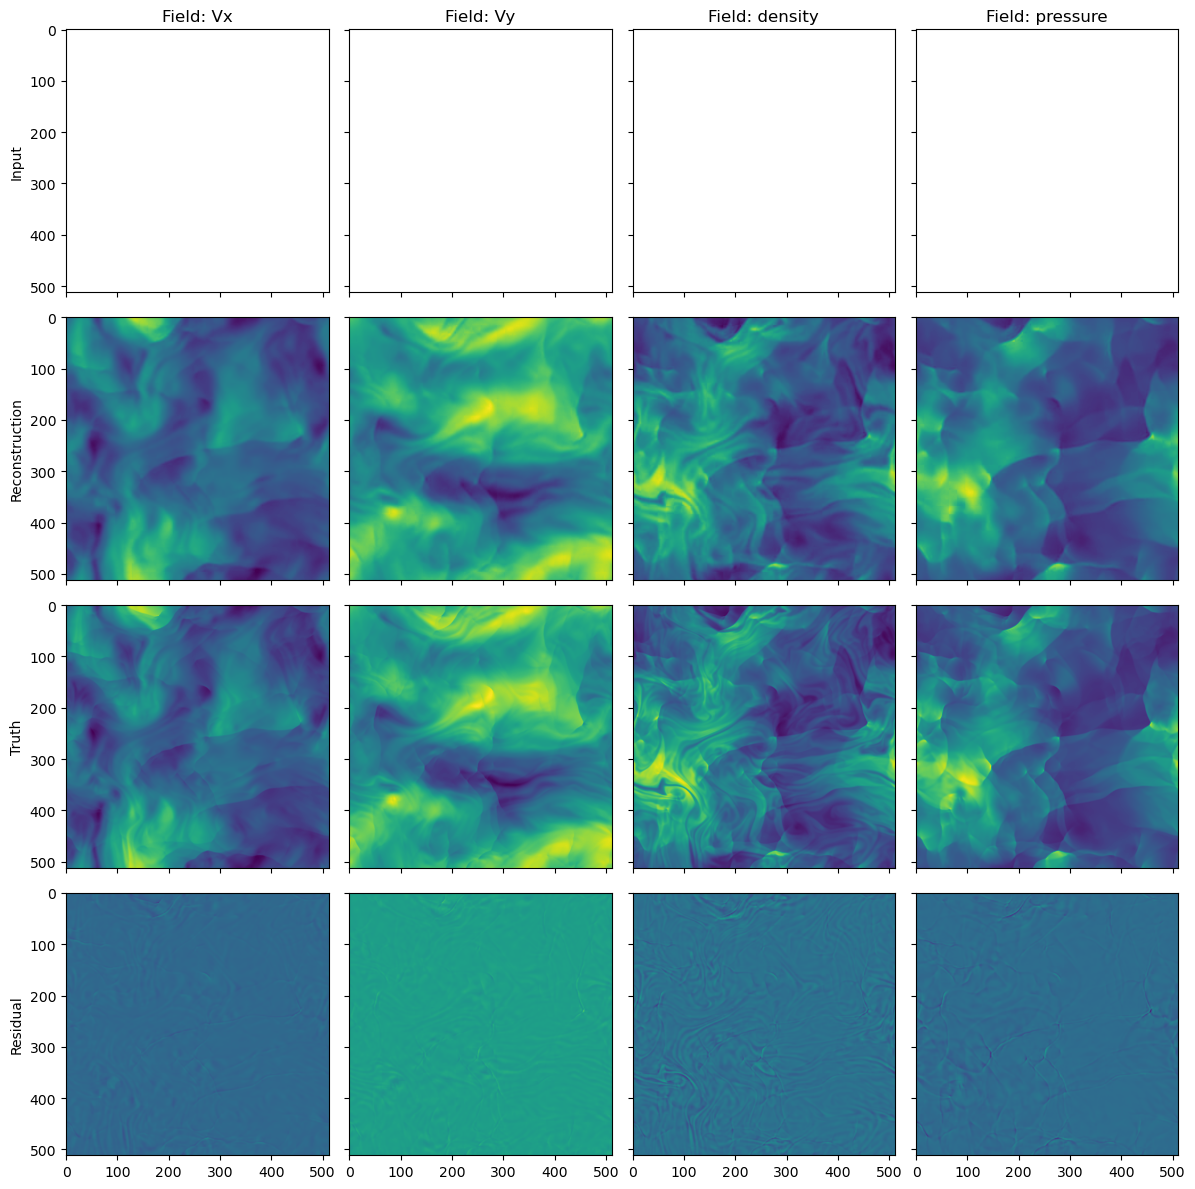

MSE Loss: 0.0074782646261155605


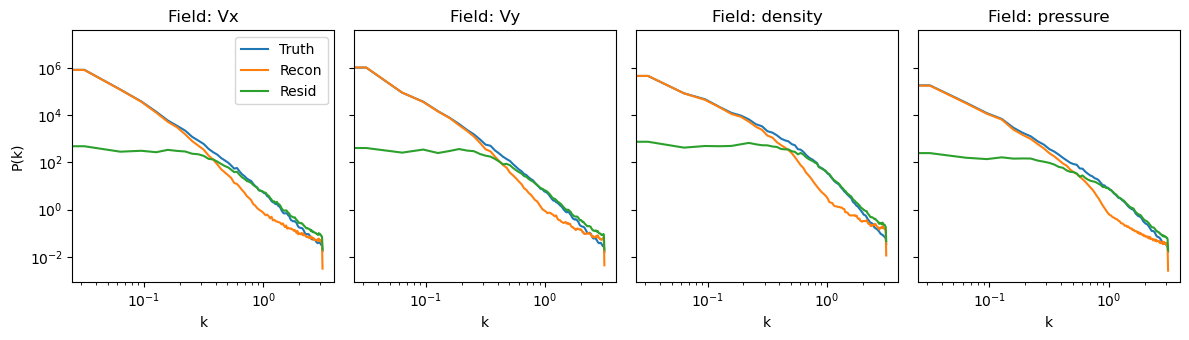

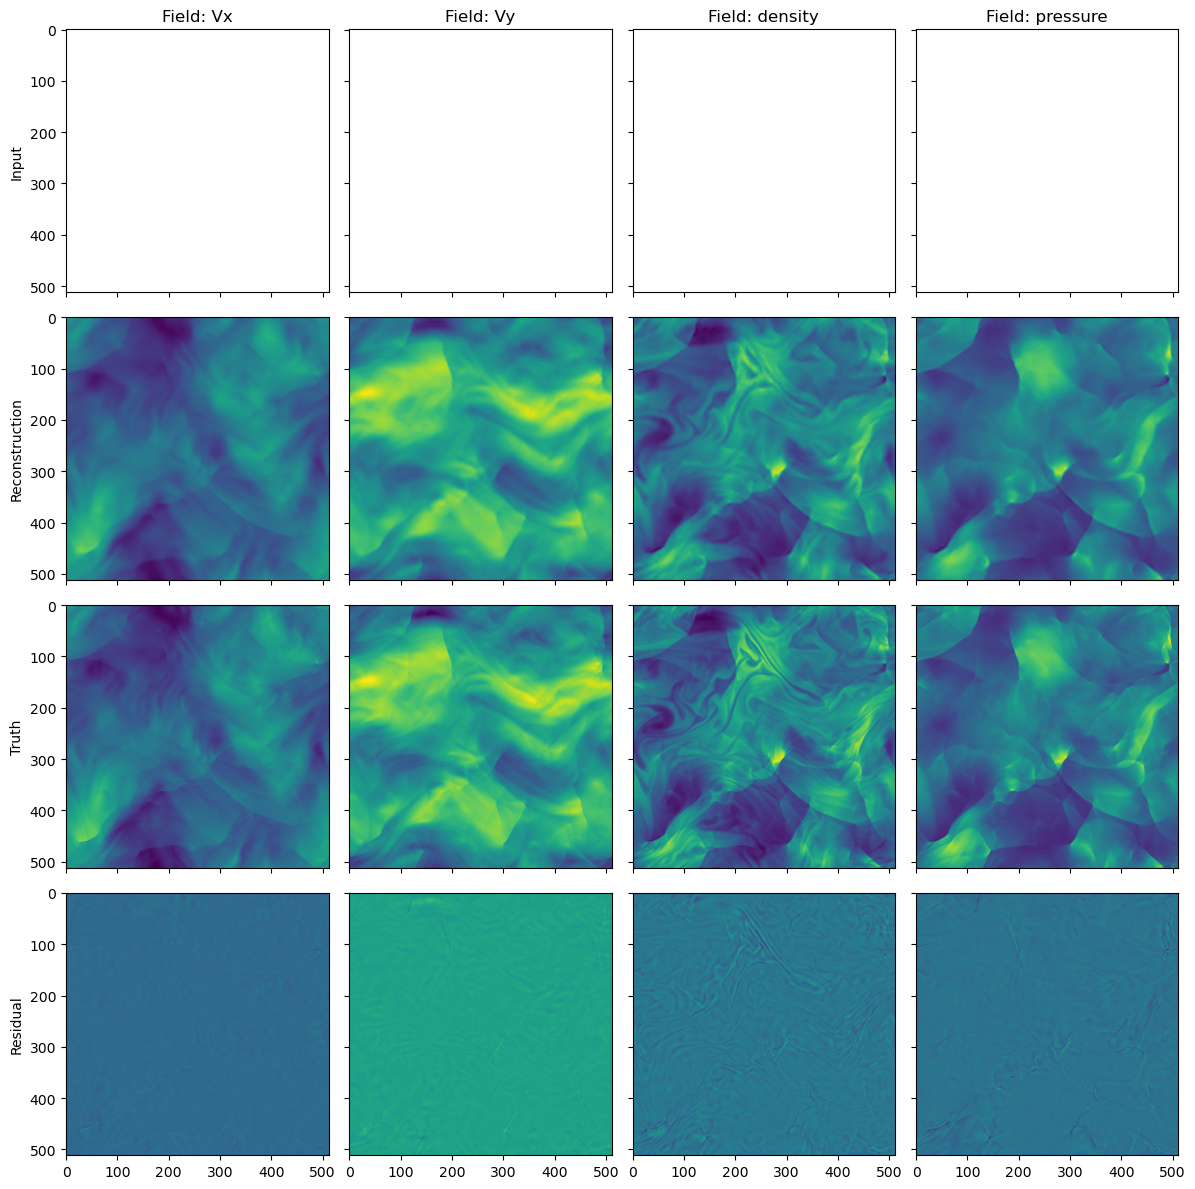

MSE Loss: 0.007560569792985916


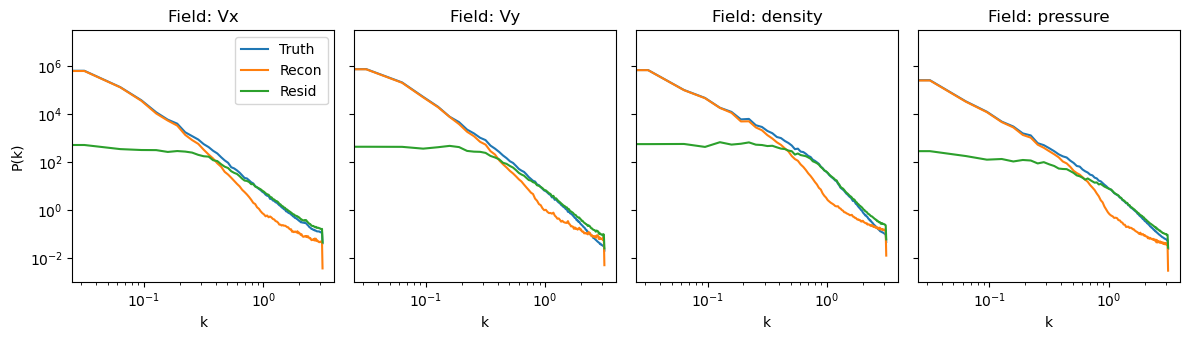

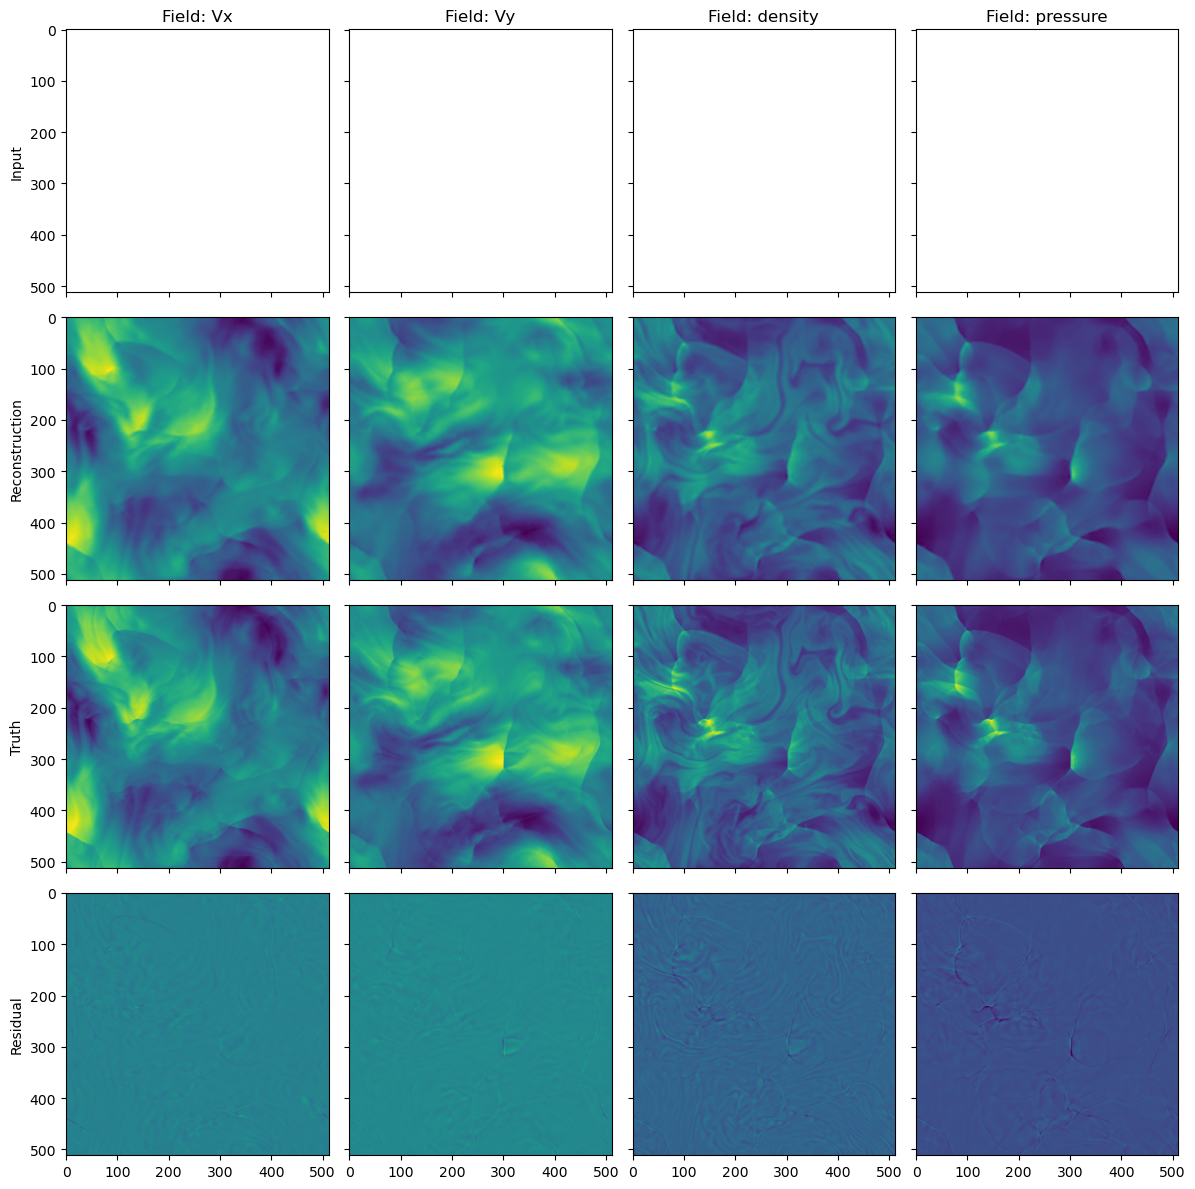

MSE Loss: 0.00876464694738388


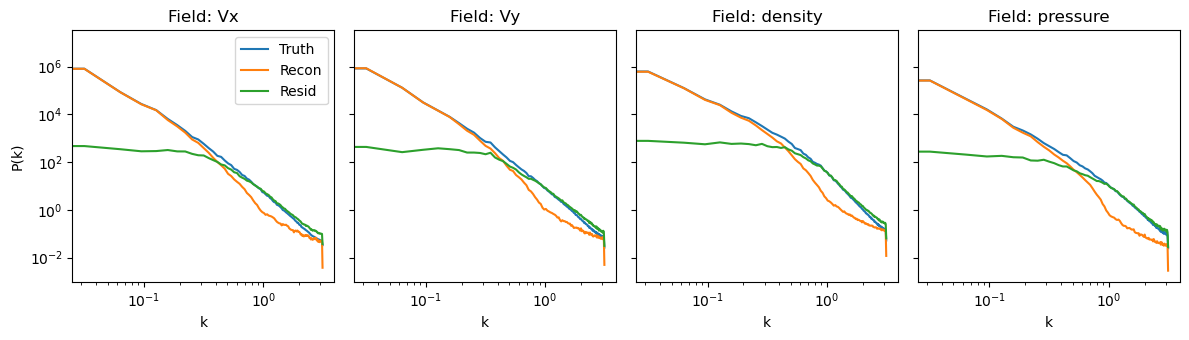

In [22]:
loss_func = nn.MSELoss()

max_examples = 5
model.eval()
for samples, masks in data_loader:
    samples = samples.to(device, non_blocking=True)
    bool_masked_pos = masks.to(device, non_blocking=True).flatten(1).to(torch.bool)

    p0, p1, p2 = 2, args.patch_size[0], args.patch_size[1]
    nchan = samples.shape[1]
    labels = get_targets(samples, bool_masked_pos, args.norm_target_mode, p0=p0, p1=p1, p2=p2)

    with torch.no_grad():
        outputs = model(samples, bool_masked_pos)
        outputs_unnorm = unnorm_batch(outputs,
                                      norm_mode=args.norm_target_mode,
                                      patch_size=(p0, p1, p2),
                                      context=samples,
                                      bool_masked_pos=bool_masked_pos)
        plot_reconstruction(samples,
                            outputs_unnorm,
                            bool_masked_pos,
                            batch_index=0,
                            frame_index=-1,
                            patch_size=(p0, p1, p2))
        loss = loss_func(input=outputs, target=labels)
        
        loss_value = loss.item()
        print("MSE Loss:", loss_value)
        max_examples -= 1
        if max_examples == 0:
            break